# Baseline 1.2
 
 In this version we are train the normalized data

In [1]:
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATASET_FOLDER = "/kaggle/input/UBC-OCEAN/"
DATASET_IMAGES = "/kaggle/input/ocean-tiles-normalized-stainlib/UBC-OCEAN-Tiles-of-Cancer-2048px-scale-0-25-Stainlib-Normalized"

## Chekout some labels

In [2]:
df_train = pd.read_csv(os.path.join(DATASET_FOLDER, "train.csv"))
# labels = list(df_train["label"].unique())
print(f"Dataset/train size: {len(df_train)}")
display(df_train.head())

Dataset/train size: 538


,image_id,label,image_width,image_height,is_tma
0,4,HGSC,23785,20008,False
1,66,LGSC,48871,48195,False
2,91,HGSC,3388,3388,True
3,281,LGSC,42309,15545,False
4,286,EC,37204,30020,False


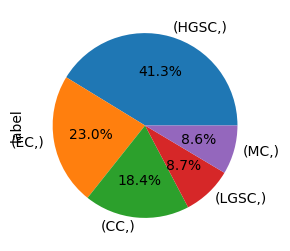

In [3]:
_= df_train[["label"]].value_counts().plot.pie(autopct='%1.1f%%', ylabel="label", figsize=(3,3))

## DataLoader

In [4]:
!pip install -U -q pytorch-lightning

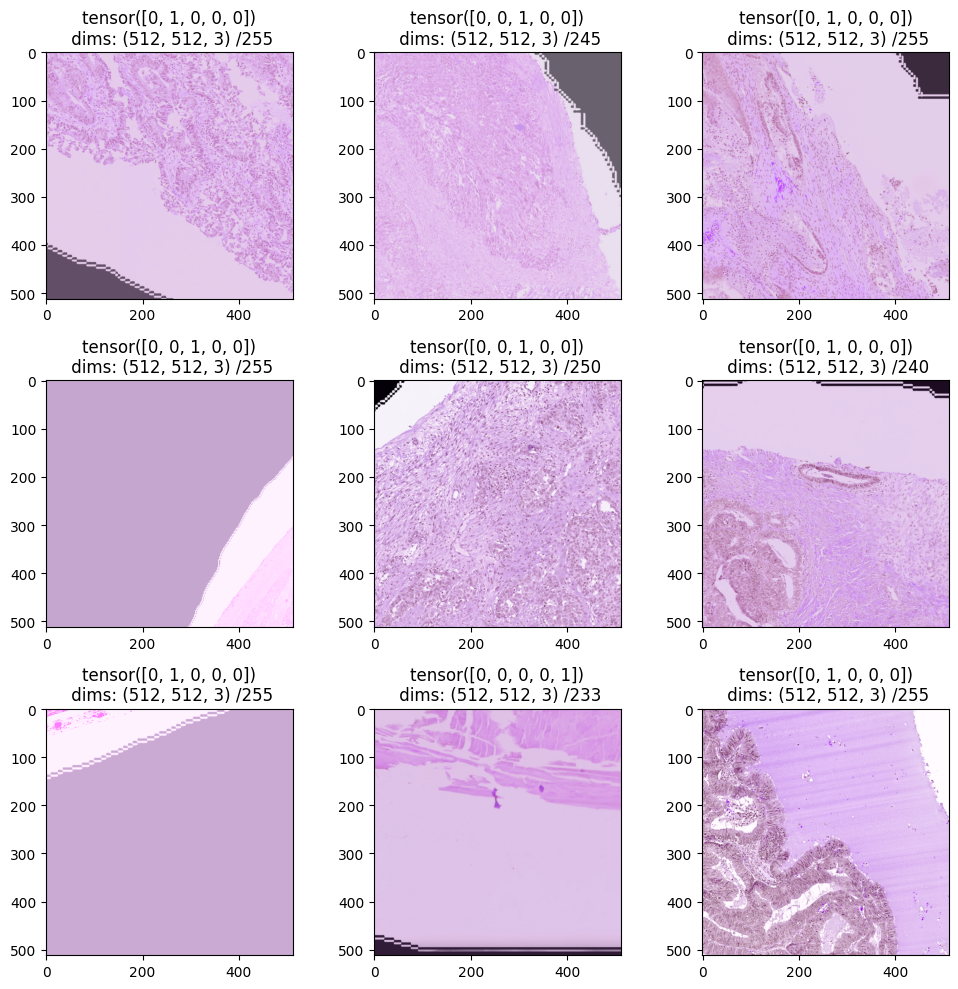

In [5]:
import os
import torch
import random
from PIL import Image
from torch.utils.data import Dataset

class CancerTilesDataset(Dataset):
    split: float = 0.90

    def __init__(
        self,
        df_data,
        path_img_dir: str =  '',
        transforms = None,
        mode: str = 'train',
        labels_lut = None,
        white_thr: int = 225,
        thr_max_bg: float = 0.2,
    ):
        assert os.path.isdir(path_img_dir)
        self.path_img_dir = path_img_dir
        self.transforms = transforms
        self.mode = mode
        self.white_thr = white_thr
        self.thr_max_bg = thr_max_bg

        self.data = df_data
        self.labels_unique = sorted(self.data["label"].unique())
        self.labels_lut = labels_lut or {lb: i for i, lb in enumerate(self.labels_unique)}
        # shuffle data
        self.data = self.data.sample(frac=1, random_state=42).reset_index(drop=True)

        # split dataset
        assert 0.0 <= self.split <= 1.0
        frac = int(self.split * len(self.data))
        self.data = self.data[:frac] if mode == 'train' else self.data[frac:]
        self.img_dirs = [glob.glob(os.path.join(path_img_dir, str(idx), "*.png")) for idx in self.data["image_id"]]
        #print(f"missing: {sum([not os.path.isfile(os.path.join(self.path_img_dir, im))
        #                       for im in self.img_names])}")
        self.labels = list(self.data['label'])

    @property
    def num_classes(self) -> int:
        return len(self.labels_lut)

    def to_one_hot(self, label: str) -> tuple:
        one_hot = [0] * self.num_classes
        one_hot[self.labels_lut[label]] = 1
        return tuple(one_hot)

    def __getitem__(self, idx: int) -> tuple:
        random.shuffle(self.img_dirs[idx])
        for img_path in self.img_dirs[idx]:
            assert os.path.isfile(img_path), f"missing: {img_path}"
            tile = np.array(Image.open(img_path))[..., :3]
#             tile = color_norm(tile)
            black_bg = np.sum(tile, axis=2) == 0
            tile[black_bg, :] = 255
            mask_bg = np.mean(tile, axis=2) > self.white_thr
            if np.sum(mask_bg) < (np.prod(mask_bg.shape) * self.thr_max_bg):
                break
        labels = self.to_one_hot(self.labels[idx])
        
#         if selt.ColorNormalize:
#             tile = self.color_norm(Image.fromarray(tile))
        
        # augmentation
        if self.transforms:
            tile = self.transforms(Image.fromarray(tile))
        #print(f"img dim: {img.shape}")
        return tile, torch.tensor(labels).to(int)

    def __len__(self) -> int:
        return len(self.data)

# ==============================
# ==============================

dataset = CancerTilesDataset(df_train, DATASET_IMAGES)

# quick view
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for i in range(9):
    img, lb = dataset[i]
    ax = axes[i // 3, i % 3]
    ax.imshow(img)
    ax.set_title(f"{lb}\n dims: {img.shape} /{np.max(img)}")
fig.tight_layout()

In [6]:
from torchvision import transforms as T
from torchvision.transforms import InterpolationMode

TRAIN_TRANSFORM = T.Compose([
    T.CenterCrop(512),
    #T.RandomResizedCrop(512, interpolation=InterpolationMode.BICUBIC, antialias=True),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ToTensor(),
    #T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
#     T.Normalize(img_color_mean, img_color_std),  # custom
])

VALID_TRANSFORM = T.Compose([
    T.CenterCrop(512),
    T.ToTensor(),
    #T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
#     T.Normalize(img_color_mean, img_color_std),  # custom
])

training dataset: 484
validation dataset: 54
5
batch labels: tensor([2, 3, 4, 2, 1])
image size: torch.Size([3, 512, 512])


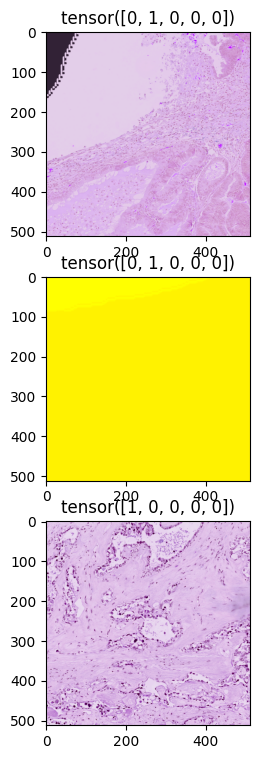

In [7]:
import multiprocessing as mproc
import pytorch_lightning as pl
from torch.utils.data import DataLoader

class CancerSubtypeDM(pl.LightningDataModule):

    def __init__(
        self,
        df_data,
        path_img_dir: str = '',
        batch_size: int = 32,
        num_workers: int = None,
        train_transforms = TRAIN_TRANSFORM,
        valid_transforms = VALID_TRANSFORM
    ):
        super().__init__()
        self.df_data = df_data
        self.path_img_dir = path_img_dir
        self.batch_size = batch_size
        self.num_workers = num_workers or mproc.cpu_count()
        self.train_dataset = None
        self.valid_dataset = None
        self.train_transforms = train_transforms
        self.valid_transforms = valid_transforms

    def prepare_data(self):
        pass

    @property
    def num_classes(self) -> int:
        assert self.train_dataset and self.valid_dataset
        return len(set(self.train_dataset.labels_unique + self.valid_dataset.labels_unique))

    def setup(self, stage=None):
        self.train_dataset = CancerTilesDataset(
            self.df_data, self.path_img_dir, mode='train', transforms=self.train_transforms)
        print(f"training dataset: {len(self.train_dataset)}")
        self.valid_dataset = CancerTilesDataset(
            self.df_data, self.path_img_dir, mode='valid', transforms=self.valid_transforms,
            # as validation is subsampled it may happen that some labels are missing
            # and so created one-hot-encoding vector will be sorter
            labels_lut=self.train_dataset.labels_lut)
        print(f"validation dataset: {len(self.valid_dataset)}")

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.valid_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )

    def test_dataloader(self):
        pass

# ==============================
# ==============================

dm = CancerSubtypeDM(df_train, DATASET_IMAGES, batch_size=12)
dm.setup()
print(dm.num_classes)

# quick view
fig = plt.figure(figsize=(3, 9))
for imgs, lbs in dm.train_dataloader():
    print(f'batch labels: {torch.sum(lbs, axis=0)}')
    print(f'image size: {imgs[0].shape}')
    for i in range(3):
        ax = fig.add_subplot(3, 1, i + 1)
        #print(np.rollaxis(imgs[i].numpy(), 0, 3).shape)
        ax.imshow(np.rollaxis(imgs[i].numpy(), 0, 3))
        ax.set_title(lbs[i])
    break

# CNN model

In [8]:
!pip install -q lion-pytorch adan-pytorch torch_optimizer

In [9]:
import timm
import torch
import torchvision
from adan_pytorch import Adan
from lion_pytorch import Lion
from torch_optimizer import AdaBound, RAdam, Yogi

from torch import nn
from torch.nn import functional as F
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score


class LitCancerSubtype(pl.LightningModule):

    def __init__(self, net, lr: float = 1e-4):
        super().__init__()
        self.net = net
        self.arch = net.pretrained_cfg.get('architecture')
        self.num_classes = net.num_classes
        self.train_accuracy = MulticlassAccuracy(num_classes=self.num_classes)
        self.val_accuracy = MulticlassAccuracy(num_classes=self.num_classes)
        self.val_f1_score = MulticlassF1Score(num_classes=self.num_classes)
        self.learn_rate = lr
        
    def forward(self, x):
        y = F.softmax(self.net(x), dim=-1)
        if y.isnan().any():
            y = torch.ones(self.num_classes) / self.num_classes
        return y

    def compute_loss(self, y_hat, y):
        return F.cross_entropy(y_hat, y.to(y_hat.dtype))

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        lbs = torch.argmax(y, axis=1)
        #print(f"{lbs=} ?= {y_hat=}")
        loss = self.compute_loss(y_hat, y)
        #print(f"{y=} ?= {y_hat=} -> {loss=}")
        self.log("train_loss", loss, logger=True, prog_bar=True)
        #print(f"{lb=} ?= {y_hat=} -> {self.train_accuracy(y_hat, lbs)}")
        self.log("train_acc", self.train_accuracy(y_hat, lbs), logger=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        lbs = torch.argmax(y, axis=1)
        loss = self.compute_loss(y_hat, y)
        self.log("valid_loss", loss, logger=True, prog_bar=False)
        self.log("valid_acc", self.val_accuracy(y_hat, lbs), logger=True, prog_bar=False)
        self.log("valid_f1", self.val_f1_score(y_hat, lbs), logger=True, prog_bar=True)

    def configure_optimizers(self):
        optimizer = AdaBound(self.parameters(), lr=self.learn_rate)
        #optimizer = RAdam(self.parameters(), lr=self.learn_rate)
        #optimizer = torch.optim.AdamW(self.parameters(), lr=self.learn_rate)
        #optimizer = Lion(self.parameters(), lr=self.learn_rate, weight_decay=1e-2)
        #optimizer = Adan(self.parameters(), lr=self.learn_rate * 10, betas=(0.02, 0.08, 0.01), weight_decay=0.02)
        
        #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        #    optimizer, T_max=self.trainer.max_epochs, eta_min=1e-6, verbose=True)
        scheduler = torch.optim.lr_scheduler.CyclicLR(
          optimizer, base_lr=self.learn_rate, max_lr=self.learn_rate * 10,
          step_size_up=5, cycle_momentum=False, mode="triangular2", verbose=True)
        #scheduler = torch.optim.lr_scheduler.OneCycleLR(
        #    optimizer, max_lr=self.learn_rate * 5, steps_per_epoch=1, epochs=self.trainer.max_epochs)
        return [optimizer], [scheduler]

# ==============================
# ==============================

# see: https://pytorch.org/vision/stable/models.html
net = timm.create_model('maxvit_tiny_tf_512', pretrained=True, num_classes=dm.num_classes)
model = LitCancerSubtype(net=net, lr=2e-5)
# print(model)

# Training


In [ ]:
logger = pl.loggers.CSVLogger(save_dir='logs/', name=model.arch)
nb_epochs = 60 if torch.cuda.is_available() else 2

# ==============================

trainer = pl.Trainer(
#     accelerator="cuda",
#     devices=2,
    # fast_dev_run=True,
    # callbacks=[swa],
    logger=logger,
    max_epochs=nb_epochs,
    precision='bf16-mixed',
    accumulate_grad_batches=14,
    #val_check_interval=0.5,
)

# ==============================

# trainer.tune(model, datamodule=dm)
trainer.fit(model=model, datamodule=dm)

training dataset: 484
validation dataset: 54
Adjusting learning rate of group 0 to 2.0000e-05.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (41) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
import seaborn as sn

metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
del metrics["step"]
metrics.set_index("epoch", inplace=True)
# display(metrics.dropna(axis=1, how="all").head())
g = sn.relplot(data=metrics, kind="line")
plt.gcf().set_size_inches(12, 4)
# plt.gca().set_yscale('log')
plt.grid()

In [ ]:
trainer.save_checkpoint("image_classification_model_CN_stainlibN.pt")